## Import

In [1]:
import sys
sys.path.append(r'\\Pund\Stab$\guest801981\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
import dill
import random
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point
from log import print_INFO_message_timestamp, print_INFO_message
from facility_location import AdjacencyMatrix, FacilityLocation, FacilityLocationReport
from retrieve_global_parameters import *

[    0.00] Initializing mpi-sppy


## Solve the facility location problem

### All day

#### Compute the distance matrix

In [4]:
ROOT_DIR = r'\/Pund/Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/'
TIMES = ["all_day", "morning", "midday", "afternoon"]

In [5]:
average_graphs = {}
for time in TIMES:
    with open(ROOT_DIR + retrieve_average_graph_path(time, True, True, True), "rb") as f:
        average_graphs[time] = dill.load(f)

In [6]:
mapping = {}
mapping_points = {}
for i, node in enumerate(average_graphs["all_day"].nodes()):
    mapping_points[i] = Point(node)
    mapping[i] = node

In [7]:
geodf = gpd.GeoDataFrame.from_dict(mapping_points, orient='index')
geodf.columns = ["geometry"]
geodf = geodf.set_geometry("geometry")

In [49]:
def recursive_gdf_buffer(geodf, geometry, init, iteration=0, max_iteration=20):
    buff = geometry.buffer(init)
    is_contained = buff.contains(geodf).geometry
    count = is_contained.sum()
    contained = is_contained.where(lambda x: x == True).dropna().index.to_numpy().tolist()
    if iteration >= max_iteration or (count>1 and count<4):
        return buff, count, contained
    else:
        if count<2:
            return recursive_gdf_buffer(geodf, geometry, init*1.3, iteration+1, max_iteration)
        elif count>3:
            return recursive_gdf_buffer(geodf, geometry, init/1.5, iteration+1, max_iteration)

In [59]:
buffer_col = []
new_col = []
new_col2 = []
for p in geodf.index:
    buff, count, contained = recursive_gdf_buffer(geodf, geodf.iloc[p].geometry, 0.00013, 0)
    buffer_col.append(buff)
    new_col.append(count)
    new_col2.append(contained)

geodf["buffer"] = buffer_col
geodf["count"] = new_col
geodf["contained"] = new_col2
geodf = geodf.set_geometry("buffer")

In [62]:
geodf.iloc[5518]


geometry                               POINT (5.35536 60.4778)
buffer       POLYGON ((5.3558426809 60.4778, 5.355840356659...
count                                                        3
contained                                   [5111, 5517, 5518]
Name: 5518, dtype: object

In [60]:
geodf["count"].value_counts().sort_index()


count
1       7
2    8987
3     849
4       1
5       2
Name: count, dtype: int64

In [137]:
sp = dict(nx.all_pairs_dijkstra_path_length(average_graphs["all_day"]))

In [241]:
distance_matrix = np.zeros((len(sp), len(sp)))
distance_matrix_mapping = {}

In [242]:
# Function to get the minimum distance between two points avoiding taking 
# into account the carriageway, i.e. the side of the road

def get_min_distance(starting_index, ending_index):
    distances = {}
    for i in geodf.iloc[starting_index].contained:
        for j in geodf.iloc[ending_index].contained:
            distances[(i, j)] = sp[mapping[i]][mapping[j]]
            
    mapped_key = min(distances, key=distances.get)
    min_distance = distances[mapped_key]
    return min_distance, mapped_key

In [243]:
print_INFO_message_timestamp("Creating distance matrix")
for i in range(len((sp))):
    if mapping_points[i] in coordinates_sampled2["all_day"].geometry:
        for j in range(len(sp)):
            if mapping_points[j] in coordinates_sampled["all_day"].geometry:
                min_dis, mapped_key = get_min_distance(i, j)
                distance_matrix[i,j] = min_dis
                distance_matrix_mapping[(i,j)] = mapped_key
    if i % 500 == 0:
        print_INFO_message("{} out of {}".format(i, len(sp)))

[09/11/23 15:29:14] INFO     Creating distance matrix
                    INFO     0 out of 9846
                    INFO     500 out of 9846
                    INFO     1000 out of 9846
                    INFO     1500 out of 9846
                    INFO     2000 out of 9846
                    INFO     2500 out of 9846
                    INFO     3000 out of 9846
                    INFO     3500 out of 9846
                    INFO     4000 out of 9846
                    INFO     4500 out of 9846
                    INFO     5000 out of 9846
                    INFO     5500 out of 9846
                    INFO     6000 out of 9846
                    INFO     6500 out of 9846
                    INFO     7000 out of 9846
                    INFO     7500 out of 9846
                    INFO     8000 out of 9846
                    INFO     8500 out of 9846
                    INFO     9000 out of 9846
                    INFO     9500 out of 9846


### Problem definition

In [8]:
times = ["all_day", "morning", "midday", "afternoon"]

In [9]:
average_graphs = {}

for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"Loading avg graph for {time}")
        path = rf"\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\average_graph_{time}_connected_splitted_firstSCC.pkl"
        with open(path, "rb") as f:
            average_graphs[time] = pkl.load(f)

                    INFO     Loading avg graph for all_day
                    INFO     Loading avg graph for morning


                    INFO     Loading avg graph for midday
                    INFO     Loading avg graph for afternoon


In [10]:
adj_paths = {time: r"\/Pund/Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/" + retrieve_adj_matrix_path(time) for time in times}
adj_paths["all_day_free_flow"] = r"\/Pund/Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/" + retrieve_adj_matrix_path("all_day", free_flow=True)

In [11]:
adj_matricies = {time: None for time in times}

for time in times:
    with open(adj_paths[time], "rb") as f:
        adj_matricies[time] = pkl.load(f)
    
with open(adj_paths["all_day_free_flow"], "rb") as f:
    adj_matricies["all_day_free_flow"] = pkl.load(f)


KeyboardInterrupt



In [ ]:
weighted_adj_matricies = {time: AdjacencyMatrix(adj_matrix=adj_matricies[time],
                                  kind="empirical",
                                  epsg=None,
                                  mode="time") for time in times}

weighted_adj_matricies["all_day_free_flow"] = AdjacencyMatrix(adj_matrix=adj_matricies["all_day_free_flow"],
                                    kind="empirical",
                                    epsg=None,
                                    mode="time")

It's not possible to solve the problem exactly using all the nodes in the graph. The problem is too big. We can try to solve it using a subset of the nodes.

In [12]:
random.seed(324324)

In [13]:
def sample_idx(idxs, sample_ratio=0.1):
    n = len(idxs)
    s = random.sample(idxs, int(n*sample_ratio))
    return s

In [14]:
def sample_matrix(matrix, idx_sample):
    n_sample = len(idx_sample)
    sample_matrix = np.zeros((n_sample, n_sample))
    for i, r in enumerate(matrix[idx_sample, :]):
        sample_matrix[i,:] = r[idx_sample]
        
    return sample_matrix

In [16]:
def sample_coords(coordinates, idx_sample):
    sample_coords = coordinates.iloc[idx_sample]
    return sample_coords

In [17]:
coordinates = pd.Series(list(average_graphs["afternoon"].nodes()))
coordinates = coordinates.apply(lambda x: Point(x))
coordinates = gpd.GeoDataFrame(geometry=coordinates)

In [18]:
RATIO1 = 0.1
RATIO2= 0.05

In [19]:
idx_sampled = sample_idx(list(range(len(average_graphs["all_day"].nodes()))), RATIO1)
idx_sampled2 = sample_idx(idx_sampled, RATIO2)

In [20]:
coordinates = {time: pd.Series(list(average_graphs[time].nodes())) for time in times}
        
for time in times:
    coordinates[time] = coordinates[time].apply(lambda x: Point(x))
    coordinates[time] = gpd.GeoDataFrame(geometry=coordinates[time])
    coordinates[time]["geometry_x"] = coordinates[time].geometry.x
    coordinates[time]["geometry_y"] = coordinates[time].geometry.y
    coordinates[time].sort_values(by=["geometry_x", "geometry_y"], inplace=True)
    coordinates[time].drop(columns=["geometry_x", "geometry_y"], inplace=True)
            
coordinates_sampled = {time: sample_coords(coordinates[time], idx_sampled) for time in times}
coordinates_sampled2 = {time: sample_coords(coordinates[time], idx_sampled2) for time in times}
        
coordinates_sampled["all_day_free_flow"] = coordinates_sampled["all_day"]
coordinates_sampled2["all_day_free_flow"] = coordinates_sampled2["all_day"]

In [21]:
handpicked_locations = [5229, 1688, 1842, 4647, 159, 2075, 2428, 361, 3477, 3745, 4731]
extra_locations = []
for i, node in enumerate(average_graphs["all_day"].nodes()):
    if i in handpicked_locations:
        extra_locations.append(Point(node))

In [22]:
extra_locations_index = []
for p in extra_locations:
    for i, e in zip(coordinates["all_day"].index, coordinates["all_day"].geometry):
        if e == p:
            extra_locations_index.append(i)

In [23]:
pd.concat([coordinates_sampled2["all_day"], gpd.GeoDataFrame(geometry=extra_locations, index=extra_locations_index)])

,geometry
7912,POINT (5.44041 60.45584)
1019,POINT (5.36390 60.30903)
7754,POINT (5.35601 60.46236)
2326,POINT (5.32774 60.29848)
1393,POINT (5.35849 60.35592)
3059,POINT (5.24348 60.36128)
4241,POINT (5.32250 60.40685)
7592,POINT (5.34228 60.46739)
107,POINT (5.46042 60.42210)
9444,POINT (5.28217 60.51599)


In [17]:
adj_sampled = {key: sample_matrix(adj_matricies[key], idx_sampled) for key in adj_matricies.keys()}

In [18]:
n_locations_to_choose = 1

In [19]:
weighted_adj_sampled = {key: AdjacencyMatrix(adj_matrix=adj_sampled[key],
                                  kind="empirical",
                                  epsg=None,
                                  mode="time") for key in adj_paths.keys()}

In [49]:
fls_gon = {key: FacilityLocation(coordinates_sampled, n_locations_to_choose, weighted_adj_sampled[key]) for key in weighted_adj_sampled.keys()}
fls_gon_plus = {key: FacilityLocation(coordinates_sampled, n_locations_to_choose, weighted_adj_sampled[key]) for key in weighted_adj_sampled.keys()}

In [20]:
fls_exact = {key: FacilityLocation(
                coordinates_sampled[key],
                n_locations_to_choose,
                weighted_adj_matricies[key],
                coordinates_sampled2[key],) 
             for key in weighted_adj_matricies.keys()}

#### Solve the problem

##### Simple Gon 

In [ ]:
for fl_gon in fls_gon.values():
    fl_gon.solve(mode = "approx")

In [24]:
print_INFO_message_timestamp("Objective value for the GON approximation")
for time, fl_gon in fls_gon.items():
    print_INFO_message(f"{time}: {round(fl_gon.solution_value/60, 3)} minutes")

[05/16/23 14:21:40] INFO     Objective value for the GON approximation
                    INFO     all_day: 32.515 minutes
                    INFO     morning: 28.679 minutes
                    INFO     midday: 29.455 minutes
                    INFO     afternoon: 32.514 minutes
                    INFO     all_day_free_flow: 27.343 minutes


In [25]:
report_gon = FacilityLocationReport(fls_gon)

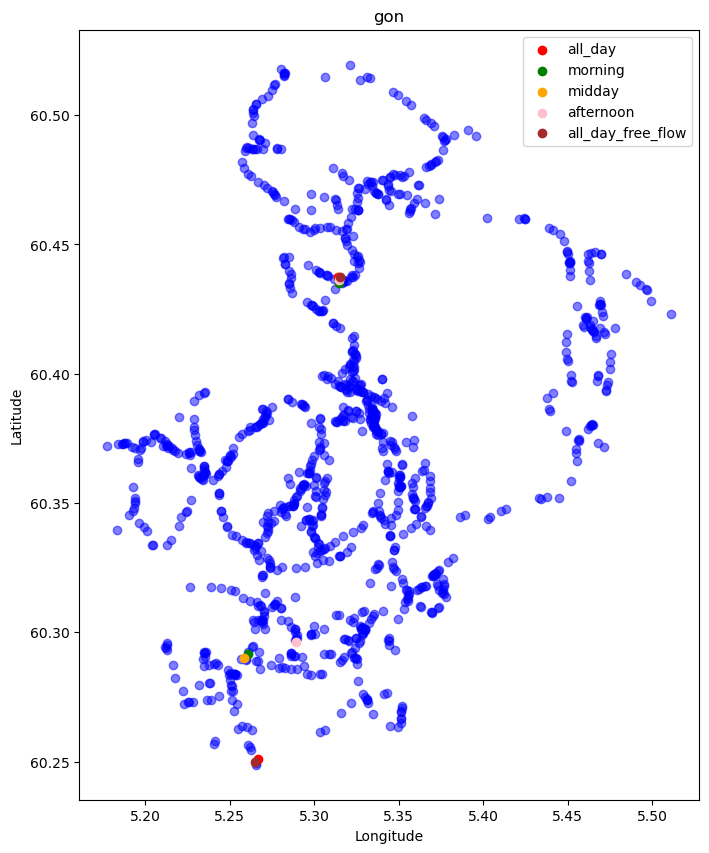

In [71]:
report_gon.graphical_keys_solutions_comparison()

##### Gon+

In [31]:
for fl_gon_plus in fls_gon_plus.values():
    fl_gon_plus.solve(mode = "approx", 
                      algorithm = "gon_plus", 
                      n_trial = len(coordinates_sampled))

[05/16/23 14:24:40] INFO     Solving the problem approximately using the GON+ algorithm...
[05/16/23 14:24:40] INFO     Solving the problem approximately using the GON+ algorithm...
[05/16/23 14:24:40] INFO     Solving the problem approximately using the GON+ algorithm...
[05/16/23 14:24:40] INFO     Solving the problem approximately using the GON+ algorithm...
[05/16/23 14:24:40] INFO     Solving the problem approximately using the GON+ algorithm...


In [32]:
print_INFO_message_timestamp("Objective value for the GON approximation")
for time, fl_gon_plus in fls_gon_plus.items():
    print_INFO_message(f"{time}: {round(fl_gon_plus.solution_value/60, 3)} minutes")

[05/16/23 14:24:41] INFO     Objective value for the GON approximation
                    INFO     all_day: 23.256 minutes
                    INFO     morning: 22.806 minutes
                    INFO     midday: 23.205 minutes
                    INFO     afternoon: 25.198 minutes
                    INFO     all_day_free_flow: 21.543 minutes


In [33]:
report_gon_plus = FacilityLocationReport(fls_gon_plus)

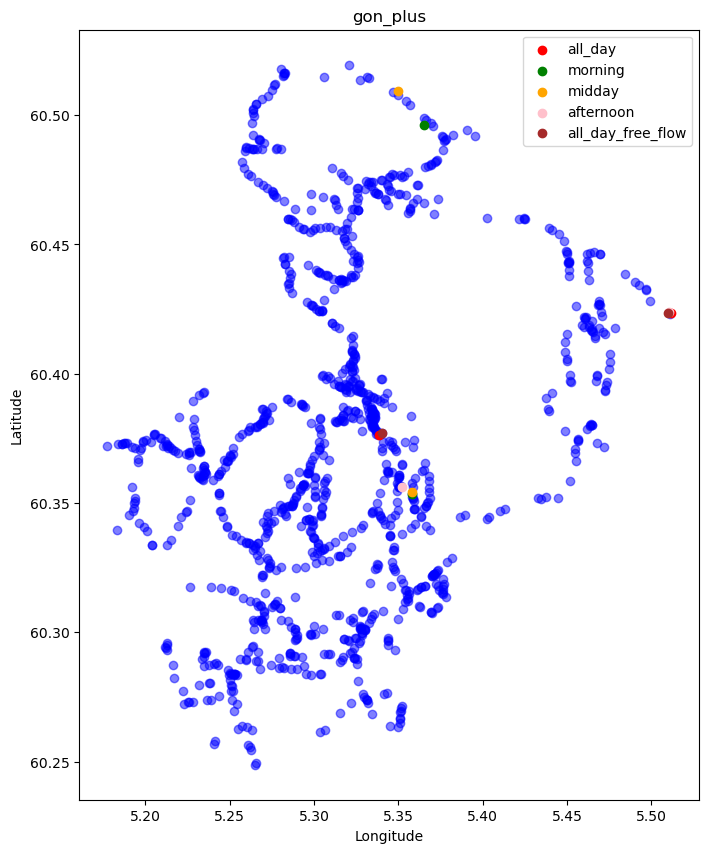

In [34]:
report_gon_plus.graphical_keys_solutions_comparison()

##### Exact 

In [21]:
fls_exact["all_day"].solve(mode = "exact")

[09/04/23 15:49:25] INFO     Solving the problem exactly...
                    INFO     Defining the abstract model...
[09/04/23 15:49:25] INFO     Initializing data...
                    INFO     Creating the instance...
[09/04/23 15:49:42] INFO     Solving the model...


[09/04/23 15:49:42] WARNING  Could not locate the 'cplex' executable, which is required for solver     ]8;id=487955;file://\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\pyomo\solvers\plugins\solvers\CPLEX.py\CPLEX.py]8;;\:]8;id=745263;file://\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\pyomo\solvers\plugins\solvers\CPLEX.py#390\390]8;;\
                             cplex                                                                                 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 fls_exact["all_day"].solve(mode = "exact")                                                   │
│   2                                                                                              │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facil │
│ ity_location_Bergen\custome_modules\facility_location.py:390 in solve                            │
│                                                                                                  │
│    387 │   │                                                                                     │
│    388 │   │   if mode == "exact":                                                               │
│    389 │   │   │   print_INFO_message_timestamp("Solving the problem exactly...")                │
│ ❱  390 │   │   │   self.__solve_exact()                                                          │
│    391 │   │                                                                                     │
│    392 │   │   elif mode == "approx":                                                            │
│    393 │   │   │   if algorithm == "gon":                                                        │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facil │
│ ity_location_Bergen\custome_modules\facility_location.py:358 in __solve_exact                    │
│                                                                                                  │
│    355 │   │   print_INFO_message_timestamp("Solving the model...")                              │
│    356 │   │   opt = SolverFactory("cplex")                                                      │
│    357 │   │                                                                                     │
│ ❱  358 │   │   self.result = opt.solve(self.instance)                                            │
│    359 │   │                                                                                     │
│    360 │   │   self.solution_value = self.instance.L.value                                       │
│    361 │   │   self.locations_index = [                                                          │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\pyomo\ │
│ opt\base\solvers.py:533 in solve                                                                 │
│                                                                                                  │
│   530 │   def solve(self, *args, **kwds):                                                        │
│   531 │   │   """Solve the problem"""                                                            │
│   532 │   │                                                                                      │
│ ❱ 533 │   │   self.available(exception_flag=True)                                                │
│   534 │   │   #                                                                                  │
│   535 │   │   # If the inputs are models, then validate that they have been                      │
│   536 │   │   # constructed! Collect suffix names to try and import from solution.               │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analys

In [26]:
for fl_exact in list(fls_exact.values()):
    fl_exact.solve(mode = "exact")

[06/23/23 09:59:41] INFO     Solving the problem exactly...
                    INFO     Defining the abstract model...
[06/23/23 09:59:41] INFO     Initializing data...
                    INFO     Creating the instance...


[06/23/23 10:01:58] INFO     Solving the model...


In [27]:
fls_exact["afternoon"].solution_value

2035.9651503892674

In [28]:
print_INFO_message_timestamp("Save the exact solutions")
for time, fl_exact in fls_exact.items():
    print_INFO_message(f"{time}")
    saving_path = r"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\07_model_output\1_locations\deterministic_exact_solutions\exact_solution_{}.pkl".format(time)
    fl_exact.save(saving_path)

[06/23/23 11:53:34] INFO     Save the exact solutions
                    INFO     afternoon
